# Overview (project objective)

In this project, I will explore whether or not the clap regression model's mean squared error will be reduced if I add topic features into regression models. The goal of this project is to improve clap regression V1.1 model and hopefully productize it. 

To stage the prototype process, this notebook will be responsible for topic modeling version 1.0. I will use unsupervised learning techniques to extract topic features from blog contents' text. Because of the nature of unsupervised learning, it's very hard to come up with a score to measure topic modeling performance. So the only way to validate the model is to compares model's lable / topic to the blog post's tags


## Contents
1. Load Data
2. Preprocess / Clean Text, Tokenization, Lemmetization/Stemming
3. TF-IDF vectorization
4. K-means clustering
5. LSA (Latent Sementic Analysis) + K-means clustering
6. LDA (Latent Dirichlet allocation)
7. Visualization / Intepretation / Simularity

In [1]:
# main import
import sys
import os
import json
import nltk
import numpy as np
import pandas as pd
import tabulate

# my import
sys.path.append('../src/')
from preprocess import MediumBlogPost

# sklearn import
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity


# visualization imports
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline

files = ['data-science.jl', 'startup.jl']

## load data

In [6]:
dfs = []
for file_name in files:
    file_path = os.path.join(os.environ['RAW_DATA_PATH'], file_name)
    with open(file_path) as f:
        for line in f:
            # get raw data
            row = MediumBlogPost(**json.loads(line)).to_frame()
            dfs.append(row)

# raw data
df = pd.concat(dfs).reset_index(drop=True)
# all raw documents
all_docs = df.contents.tolist()

## Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library. Stop words are words like "a", "the", or "in" which don't convey significant meaning. Stemming is the process of breaking a word down into its root.

In [7]:
def tokenization(text):
    # tokenize
    tokens = nltk.RegexpTokenizer(pattern=r"(?u)\b\w\w+\b").tokenize(text)
    # remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    return [t for t in tokens if t.lower() not in stopwords]

def tokenization_and_stemming(text):
    # tokenize and remove stopwords
    tokens = tokenization(text)
    # stem
    porter = nltk.PorterStemmer()
    stems = [porter.stem(t) for t in tokens]
    return stems

tokenization_and_stemming(all_docs[1][:188])

['last',
 'post',
 'taken',
 'look',
 'boston',
 'price',
 'dataset',
 'load',
 'directli',
 'scikit',
 'learn',
 'post',
 'go',
 'build',
 'linear',
 'regress',
 'model',
 'convert']

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [8]:
# # get list of stems and list of original tokens
# stems_list = []
# tokens_list = []
# for doc in all_docs:
#     # add to stems
#     stems = tokenization_and_stemming(doc)
#     stems_list.extend(stems)
#     # add to tokens
#     tokens = tokenization(doc)
#     tokens_list.extend(tokens)

# # get a mapping
# stem_to_word_dict = {stems_list[x]: tokens_list[x] for x in range(len(stems_list))}

In [9]:
stem_to_word_dict = pd.read_pickle('../data/stem_to_word_dict.pkl')
print(stem_to_word_dict['varianc'])

variance


In [10]:
print('total size of the vocabulary from all blog posts:', len(stem_to_word_dict.keys()))

total size of the vocabulary from all blog posts: 117401


## TF-IDF
use sklearn implementation with our own tokenizer

In [11]:
# define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(
    min_df=2, # words with low document frequency usually are rare words like person's name, or rare entity name
    max_df=0.95, # words with high document frequency usually are common words like 'is', 'are', 'yes', 'what', ..
    max_features=10000, # we only include top 10000 words with highest tf-idf weights out of 116392
    stop_words='english',
    use_idf=True,
    tokenizer=tokenization_and_stemming, # our customized tokenizer
    ngram_range=(1,1) # not considering bi-gram
)

# get tf-idf features
tfidf_matrix = tfidf_vectorizer.fit_transform(all_docs)
# get all selected words
tfidf_selected_words = tfidf_vectorizer.get_feature_names()
# print
tfidf_matrix.shape

(25021, 10000)

## K-means clustering

1. look for the elbow to determine the optimal number of clusters
2. check the number of samples per group to confirm we have balanced samples accross k-means groups
3. calculate claps aggregate stats (eg. mean, ...) group by k-means group to check whether there are regression signals
4. print top n important features (words) from every group's centroid and some blog post's titles to verify whether the grouping actually makes sense
5. use PCA / T-SNE to visualize k-means grouping effect

### 1. look for the optimal number of clusters for K-means grouping

In [12]:
# init potential n_clusters
n_clusters_list = list(range(1, 60, 1))
# init scores
scores = []
# init models for cache
kms = {}
for n_clusters in n_clusters_list:
    km = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=99
    ).fit(tfidf_matrix)
    # save models
    kms.update({n_clusters: km})
    # save score
    scores.append(-1 * km.score(tfidf_matrix))

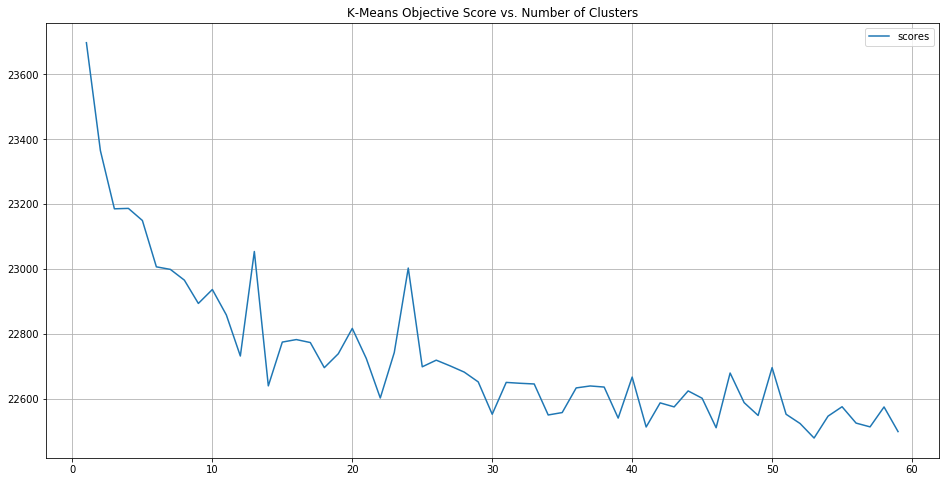

In [13]:
# look for elbow to determine optimal number of clusters
pd.DataFrame({'scores': scores}, index=n_clusters_list).plot(
    figsize=(16, 8),
    title='K-Means Objective Score vs. Number of Clusters',
    grid=True
)

In [14]:
# pick optimal K-means Model
n = 15
km = kms[n]
clusters = km.labels_.tolist()

# create DataFrame df_clusters for clustering analysis
data_clusters = {
    'title': df.title.values,
    'mins_read': df.mins_read.values,
    'claps': df.claps.values,
    'cluster': clusters
}
df_clusters = pd.DataFrame(
    data_clusters,
    index=[clusters],
    columns=['title', 'mins_read', 'claps', 'cluster']
)

df_clusters.head(3)

,title,mins_read,claps,cluster
10,The Woman Behind the Data – Data Wonderment – ...,2,0,10
10,CoreML — Building the model for Boston Prices ...,3,1,10
10,TRANSFER LEARNING DEMYSTIFIED – Najeeb Khan – ...,4,1,10


### 2. check the number of samples per group to confirm we have balanced samples accross k-means groups

In [15]:
print("Number of blog posts included in each cluster:")
df_clusters['cluster'].value_counts().to_frame()

Number of blog posts included in each cluster:


,cluster
7,8200
3,3569
10,3378
11,3333
2,1427
8,1251
4,1205
0,1084
1,698
6,642


### 3. calculate claps aggregate stats (eg. mean, ...) group by k-means cluster to check whether there are regression signals

In [16]:
print("High level aggregate statistics of 'claps' per cluster:")
df_clusters.groupby('cluster')['claps'].agg(['mean', 'median', 'max', 'min', 'count'])

High level aggregate statistics of 'claps' per cluster:


,mean,median,max,min,count
cluster,,,,,
0,89.548893,2.0,12300,0,1084
1,200.775072,11.0,40000,0,698
2,119.120533,10.0,8300,0,1427
3,87.414962,10.0,21000,0,3569
4,241.342739,50.0,67000,0,1205
5,189.600000,30.0,847,0,5
6,136.808411,6.0,42000,0,642
7,58.554024,1.0,14900,0,8200
8,129.172662,14.0,17300,0,1251


### 4. display top n highest weighted words from every cluster's centroid and some blog post's titles to verify whether the grouping actually makes sense

In [17]:
# let take top n words
topn = 5
# get sorted weighted word index in cluster centroid
sorted_idx_centroids = km.cluster_centers_.argsort()[:, ::-1] 
# init cluster_keywords for storing key words
cluster_keywords = {}

print("<Blog post clustering result by K-means>")
for i in df_clusters.cluster.sort_values().unique():
    print('Cluster', i)
    print('num blogs:', len(df_clusters.loc[i]))
    print('average claps:', round(df_clusters.loc[i, 'claps'].mean(), 2))
    print('key words:')
    # record key words for each cluster
    cluster_keywords[i] = [stem_to_word_dict[tfidf_selected_words[idx]] for idx in sorted_idx_centroids[i, :topn]]
    print(cluster_keywords[i])
    print('sample titles:')
    print(df_clusters.loc[i]['title'].sample(n=1, replace=False).values.tolist())
    print()

<Blog post clustering result by K-means>
Cluster 0
num blogs: 1084
average claps: 89.55
key words:
['business', 'company', 'work', 'start', 'need']
sample titles:
['Cost Benefits Through Business Organization Technology Assessment']

Cluster 1
num blogs: 698
average claps: 200.78
key words:
['app', 'users', 'content', 'posts', 'use']
sample titles:
['Sultan Moni announces new expansion plan for Zatiq – Tech World – Medium']

Cluster 2
num blogs: 1427
average claps: 119.12
key words:
['product', 'customer', 'markets', 'users', 'company']
sample titles:
['How our community built a $33M brand – Morning Recovery – Medium']

Cluster 3
num blogs: 3569
average claps: 87.41
key words:
['company', 'Teams', 'startup', 'work', 'tech']
sample titles:
['A Big Welcome to our CDO Alex Kerezy – DeFiner – Medium']

Cluster 4
num blogs: 1205
average claps: 241.34
key words:
['blockchain', 'Token', 'ICO', 'cryptocurrencies', 'crypto']
sample titles:
['Dystem press release — June 2018 – Dystem – Medium']


#### Obervations about the claps vs. kmean clusters
1. Medium readers tends to prefer reading blog posts with contents about people, work, content, app, users, product, blockchain topics. And blog posts with those topic are generally given more claps
2. Medium readers tends to give less claps to blog posts with content focus on data, learning, company, teams, topics

### 5. PCA visualize K-means clusters

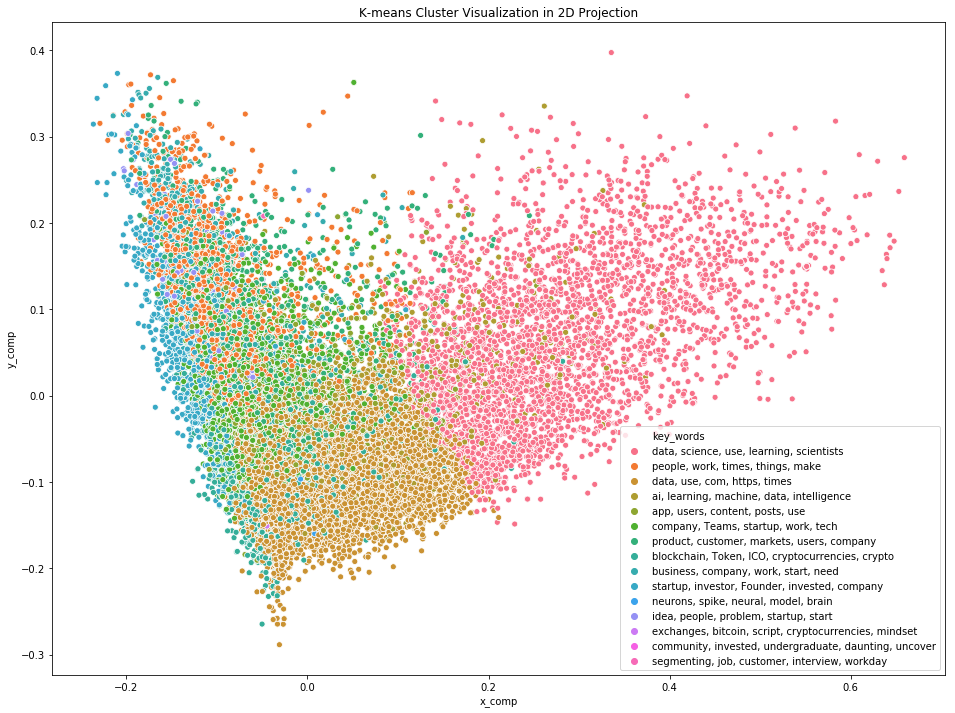

In [18]:
# train PCA
pca = PCA(n_components=2).fit(tfidf_matrix.toarray())
# get 2-D representation of our data
X_pca = pca.transform(tfidf_matrix.toarray())
# convert to dataframe for visualization
df_pca = pd.DataFrame(X_pca, columns=['x_comp', 'y_comp'])
df_pca['cluster'] = df_clusters['cluster'].copy().values
df_pca['key_words'] = df_pca.cluster.map(cluster_keywords).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('K-means Cluster Visualization in 2D Projection')
sns.scatterplot(
    x="x_comp",
    y="y_comp",
    hue='key_words',
    data=df_pca,
    ax=ax
)

### 5. TSNE visualize K-means clusters

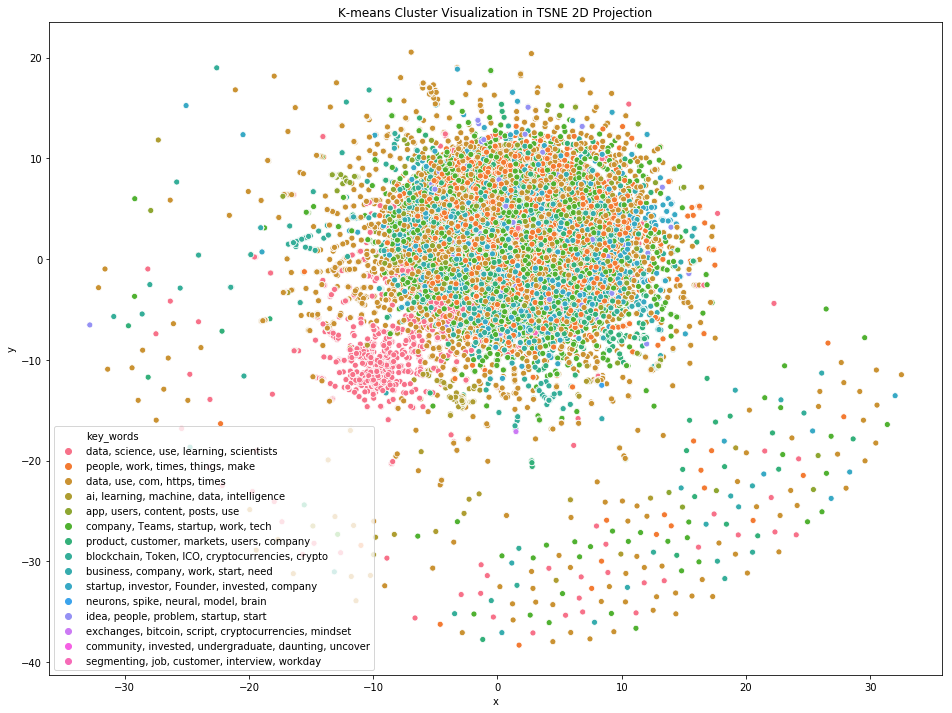

In [19]:
# get 2-D representation of our data
# X_tsne_embedded = TSNE(n_components=2, random_state=99).fit_transform(tfidf_matrix.toarray())
# pd.to_pickle(X_tsne_embedded, '../data/tsne_embedded.pkl')
X_tsne_embedded = pd.read_pickle('../data/tsne_embedded.pkl')
# convert to dataframe for visualization
df_tsne = pd.DataFrame(X_tsne_embedded, columns=['x', 'y'])
df_tsne['cluster'] = df_clusters['cluster'].copy().values
df_tsne['key_words'] = df_tsne.cluster.map(cluster_keywords).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('K-means Cluster Visualization in TSNE 2D Projection')
sns.scatterplot(
    x="x",
    y="y",
    hue='key_words',
    data=df_tsne,
    ax=ax
)

#### Obervations about k-means clustering
1. t-SNE visualization shows much better details than PCA visualization
2. K-means does a good job on clustering big groups roughly. The left side of plot is mostly occupied by Blog posts tagged with 'Startup', the right side of the plot is mostly occupied by 'Data Science'
3. However, we can see there are a lot more clusters than we thought in these blog posts. And there are a lot of individual topic that are further away from the majority, those are out there on their individual island, as shown at the upper part of the plot
4. We can see one drawback about K-means clustering here is that, K-means clusters groups based on linear distance. However, in the data high-dimensional space, there is non-linear pattern or manifold pattern
5. Roughly speaking, excluding those individual topics, there are 30 topics

## LSA + K-means clustering

In [20]:
# LSA
svd = TruncatedSVD(n_components=100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
# dimension reduction
lsa_matrix = lsa.fit_transform(tfidf_matrix)

In [21]:
# init potential n_clusters
n_clusters_list = list(range(1, 60, 1))
# init scores
scores = []
# init models for cache
kms = {}
for n_clusters in n_clusters_list:
    km = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=99
    ).fit(lsa_matrix)
    # save models
    kms.update({n_clusters: km})
    # save score
    scores.append(-1 * km.score(lsa_matrix))

### 1. look for the optimal number of clusters for K-means grouping

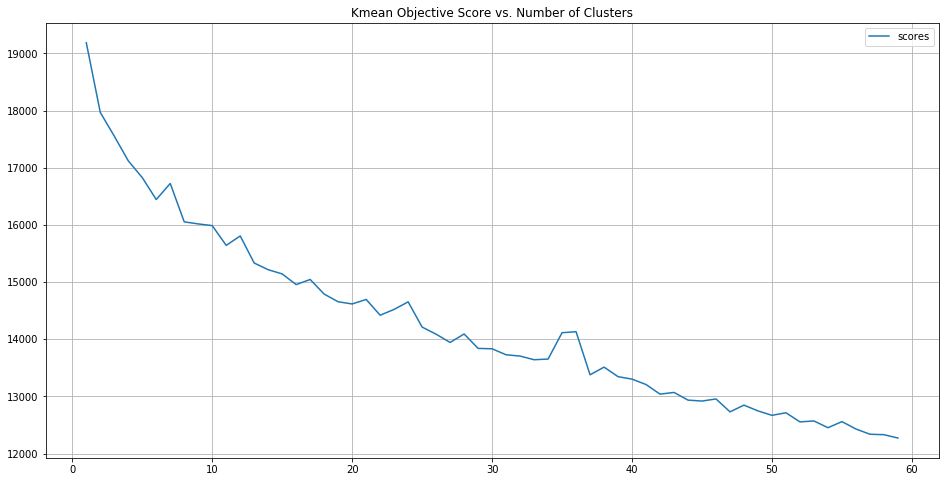

In [22]:
# look for elbow to determine optimal number of clusters
pd.DataFrame({'scores': scores}, index=n_clusters_list).plot(
    figsize=(16, 8),
    title='Kmean Objective Score vs. Number of Clusters',
    grid=True
)

In [23]:
# pick optimal K-means Model
n = 15
km = kms[n]
clusters = km.labels_.tolist()

# create DataFrame df_clusters for clustering analysis
data_clusters = {
    'title': df.title.values,
    'mins_read': df.mins_read.values,
    'claps': df.claps.values,
    'cluster': clusters
}
df_clusters = pd.DataFrame(
    data_clusters,
    index=[clusters],
    columns=['title', 'mins_read', 'claps', 'cluster']
)

df_clusters.head(3)

,title,mins_read,claps,cluster
9,The Woman Behind the Data – Data Wonderment – ...,2,0,9
4,CoreML — Building the model for Boston Prices ...,3,1,4
4,TRANSFER LEARNING DEMYSTIFIED – Najeeb Khan – ...,4,1,4


### 3. calculate claps aggregate stats (eg. mean, ...) group by k-means cluster to check whether there are regression signals

In [24]:
print("High level aggregate statistics of 'claps' per cluster:")
df_clusters.groupby('cluster')['claps'].agg(['mean', 'median', 'max', 'min', 'count'])

High level aggregate statistics of 'claps' per cluster:


,mean,median,max,min,count
cluster,,,,,
0,90.327398,6,21000,0,2471
1,190.021179,7,45000,0,2172
2,244.240385,51,67000,0,1456
3,76.236923,4,2800,0,325
4,94.720460,5,14900,0,1828
5,33.217822,0,1700,0,1414
6,138.537438,6,42000,0,601
7,130.039674,11,9300,0,1840
8,408.905340,14,103000,0,2884


### 4. display top n highest weighted words from every cluster's centroid and some blog post's titles to verify whether the grouping actually makes sense

In [25]:
# let take top n words
topn = 5
# get sorted weighted word index in cluster centroid
df_tfidf_cluster = pd.DataFrame(tfidf_matrix.todense())
df_tfidf_cluster['cluster'] = df_clusters.cluster.copy().values
cluster_centers = df_tfidf_cluster.groupby('cluster').mean().values
sorted_idx_centroids = cluster_centers.argsort()[:, ::-1] 
# init cluster_keywords for storing key words
cluster_keywords = {}

print("<Blog post clustering result by K-means>")
for i in df_clusters.cluster.sort_values().unique():
    print('Cluster', i)
    print('num blogs:', len(df_clusters.loc[i]))
    print('average claps:', round(df_clusters.loc[i, 'claps'].mean(), 2))
    print('key words:')
    # record key words for each cluster
    cluster_keywords[i] = [stem_to_word_dict[tfidf_selected_words[idx]] for idx in sorted_idx_centroids[i, :topn]]
    print(cluster_keywords[i])
    print('sample titles:')
    print(df_clusters.loc[i]['title'].sample(n=5, replace=False).values.tolist())
    print()

<Blog post clustering result by K-means>
Cluster 0
num blogs: 2471
average claps: 90.33
key words:
['company', 'Teams', 'business', 'work', 'employees']
sample titles:
['#HackDay — An event that introduced our culture to us!', 'GoEuro — Behind the scenes – Landing Festival Team – Medium', 'Great adventure... Lesson for me  business should be treated as one irrespective of where it’s coming...', 'This Simple Hack Will Tell You if Your Staff Is About to Give Up', 'Say no already – Ricky Willianto – Medium']

Cluster 1
num blogs: 2172
average claps: 190.02
key words:
['people', 'content', 'Social', 'use', 'app']
sample titles:
['Are you approachable by your fans & followers? – Pranjal Taneja – Medium', 'Blurt out your idea – Sai Bharath – Medium', 'Top 10 Best Reddit Alternative Websites (Sites Like Reddit)', 'THE WOAH EXPERIENCE – AD DISCOVERY AND CREATIVITY LAB – Medium', "Social Media: It’s your choice. – Aimee's Blog – Medium"]

Cluster 2
num blogs: 1456
average claps: 244.24
key word

### 5. TSNE visualize K-means clusters

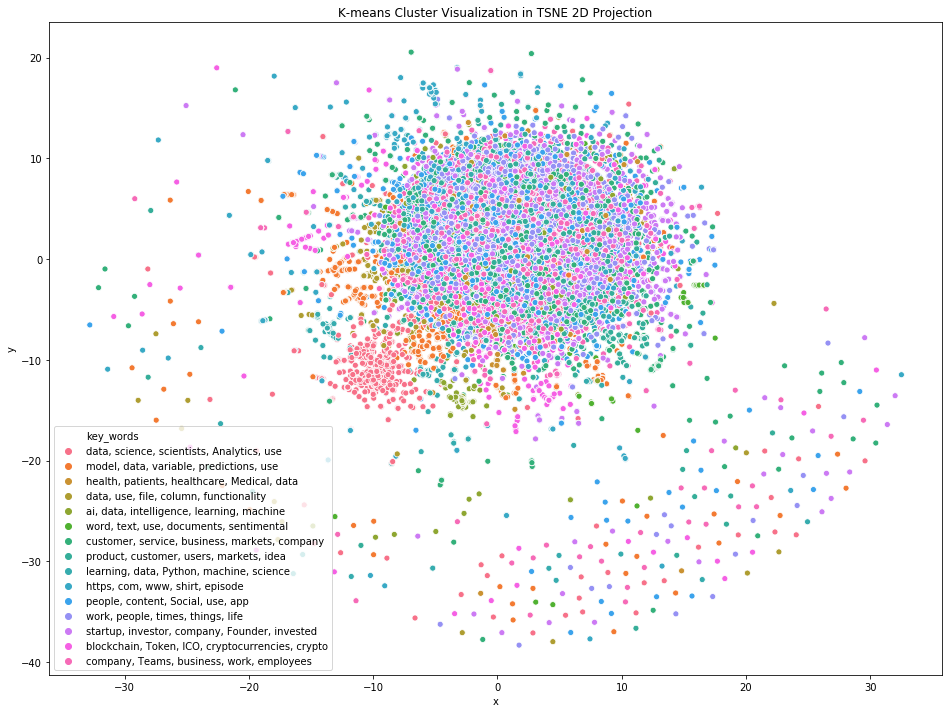

In [26]:
# get 2-D representation of our data
# X_tsne_embedded = TSNE(n_components=2, random_state=99).fit_transform(tfidf_matrix.toarray())
X_tsne_embedded = pd.read_pickle('../data/tsne_embedded.pkl')
# convert to dataframe for visualization
df_tsne = pd.DataFrame(X_tsne_embedded, columns=['x', 'y'])
df_tsne['cluster'] = df_clusters['cluster'].copy().values
df_tsne['key_words'] = df_tsne.cluster.map(cluster_keywords).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('K-means Cluster Visualization in TSNE 2D Projection')
sns.scatterplot(
    x="x",
    y="y",
    hue='key_words',
    data=df_tsne,
    ax=ax
)

#### Obervations about LSA + k-means clustering
1. LSA + k-means seems to be able to catch more non-linearity in the features space
2. the clusters are occuppying larger space 

## Topic Modeling - LDA (Latent Dirichlet allocation)
1. vectorize docs using Count vectorizer
2. check the number of samples per group to confirm we have balanced samples accross different topics
3. calculate claps aggregate stats (eg. mean, ...) group by topic to check whether there are regression signals
4. print top n frequent words in each topic's distribution and some blog post's titles to verify whether the grouping actually makes sense
5. use T-SNE to visualize LDA topic modeling effect

### 1. vectorize docs using Count vectorizer

In [27]:
# get bag of words matrix
tf_vectorizer = CountVectorizer(
    min_df=2, # words with low document frequency usually are rare words like person's name, or rare entity name
    max_df=0.95, # words with high document frequency usually are common words like 'is', 'are', 'yes', 'what', ..
    max_features=10000, # we only include top 10000 words with highest tf-idf weights out of 116392
    stop_words='english',
    tokenizer=tokenization_and_stemming, # our customized tokenizer
    ngram_range=(1,1) # not considering bi-gram
)

# get tf-idf features
tf_matrix = tf_vectorizer.fit_transform(all_docs)
# get all selected words
tf_selected_words = tf_vectorizer.get_feature_names()
# print
tf_matrix.shape

(25021, 10000)

In [56]:
# train LDA model
n_topics = 15
# lda = LatentDirichletAllocation(
#     n_components=n_topics,
#     learning_method='online',
#     learning_offset=50,
#     n_jobs=-1,
#     random_state=99
# ).fit(tf_matrix)
# # reduce dimension of tf_matrix to n_topics
# lda_matrix = lda.transform(tf_matrix)

# short cut
lda = joblib.load('../data/lda.pkl')
lda_matrix = pd.read_pickle('../data/lda_matrix.pkl')

/Users/Kevin/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.19.2 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [83]:
# create DataFrame df_topics for topic analysis
topics = np.argsort(lda_matrix, axis=1)[:, ::-1][:, 0]
data_topics = {
    'title': df.title.values,
    'mins_read': df.mins_read.values,
    'claps': df.claps.values,
    'topic': np.argsort(lda_matrix, axis=1)[:, ::-1][:, 0]
}
df_topics = pd.DataFrame(
    data_topics,
    index=[topics],
    columns=['title', 'mins_read', 'claps', 'topic']
)
df_topics.head(3)

,title,mins_read,claps,topic
13,The Woman Behind the Data – Data Wonderment – ...,2,0,13
9,CoreML — Building the model for Boston Prices ...,3,1,9
9,TRANSFER LEARNING DEMYSTIFIED – Najeeb Khan – ...,4,1,9


### 3. calculate claps aggregate stats (eg. mean, ...) group by topic to check whether there are regression signals

In [85]:
print("High level aggregate statistics of 'claps' for each topic:")
df_topics.groupby('topic')['claps'].agg(['mean', 'median', 'max', 'min', 'count'])

High level aggregate statistics of 'claps' for each topic:


,mean,median,max,min,count
topic,,,,,
0,43.590909,1,1700,0,264
1,73.904198,8,10500,0,2025
2,167.864646,24,13500,0,990
3,31.811475,0,2200,0,122
4,93.904110,5,3100,0,803
5,27.365535,0,1300,0,383
6,232.586506,10,103000,0,8641
7,232.875000,0,67000,0,336
8,55.863391,1,6700,0,3155


### 4. print top n frequent words in each topic's distribution and some blog post's titles to verify whether the grouping actually makes sense

In [110]:
# let take top n words
topn = 5
# get word distribions for each topic
topic_word_distribution = lda.components_
# get sorted word index for each topic (most important words ranked earlier)
sorted_idx_topics = np.argsort(topic_word_distribution, axis=1)[:, ::-1]
# init topic_keywords for storing key words
topic_keywords = {}

print("<Blog post clustering result by K-means>")
for i in df_topics.topic.sort_values().unique():
    print('Topic', i)
    print('num blogs:', len(df_topics.loc[i]))
    print('average claps:', round(df_topics.loc[i, 'claps'].mean(), 2))
    print('key words:')
    # record key words for each topic
    topic_keywords[i] = [stem_to_word_dict[tf_selected_words[idx]] for idx in sorted_idx_topics[i, :topn]]
    print(topic_keywords[i])
    print('sample titles:')
    print(df_topics.loc[i]['title'].sample(n=5, replace=False).values.tolist())
    print()

<Blog post clustering result by K-means>
Topic 0
num blogs: 264
average claps: 43.59
key words:
['years', 'game', '000', '10', 'Teams']
sample titles:
['Python code examples of PCA v.s. SVD – Yang Zhang – Medium', 'How does the automatic waitlist work? – OpenSports – Medium', 'Mudanzas y Enlaces – Mudanzas y Enlaces – Medium', 'Batter Up! Predicting Hitter Performance – Gerrit Hall – Medium', 'Machine Learning for Player Analytics in Tomb Raider: Underworld']

Topic 1
num blogs: 2025
average claps: 73.9
key words:
['startup', 'company', 'Founder', 'technology', 'innovators']
sample titles:
['Why chinese startups conquer the world! – Josie Wermter – Medium', 'Building our startup community — Karen Lawson, CEO of Slingshot', 'SWFT Blockchain won the second place at the “2018 (Seventh) Yangcheng Lake Maker Competition”', 'ModuleQ Announces Addition of Atsushi Taira of Mistletoe to Board of Directors', 'CREDFORCE SCORES YET ANOTHER BLUE RIBBON, THIS TIME AT THE ASIA PACIFIC ENTREPRENEURSHI

In [112]:
topic_keywords

{0: ['years', 'game', '000', '10', 'Teams'],
 1: ['startup', 'company', 'Founder', 'technology', 'innovators'],
 2: ['blockchain', 'invested', 'investor', 'Token', 'money'],
 3: ['event', 'Women', '2018', 'conference', 'pm'],
 4: ['users', 'app', 'use', 'product', 'designed'],
 5: ['food', 'home', 'cities', 'travels', 'times'],
 6: ['people', 'make', 'times', 'work', 'like'],
 7: ['secure', 'information', 'use', 'risk', 'insurance'],
 8: ['business', 'company', 'product', 'customer', 'markets'],
 9: ['model', 'use', 'learning', 'trained', 'predictions'],
 10: ['com', 'https', 'www', 'Social', 'Media'],
 11: ['data', 'values', 'use', 'numbers', 'variable'],
 12: ['data', 'science', 'learning', 'ai', 'machine'],
 13: ['work', 'learning', 'Teams', 'job', 'start'],
 14: ['data', 'use', 'codes', 'Python', 'file']}

#### Obervations about the claps vs. LDA topics
1. LDA topic clustering seems to yeild a more sensible clustering result than using K-Means based on the key words and blog post's titles
2. Both LDA and K-means methods like group of ['people', 'make', 'times', 'work', 'like'], dislike group of ['com', 'https', 'www', 'Social', 'Media']
3. In general, readers prefer trendy topic like blockchain, Entrepreneurship, ..

### 5. TSNE visualize LDA topic clustering

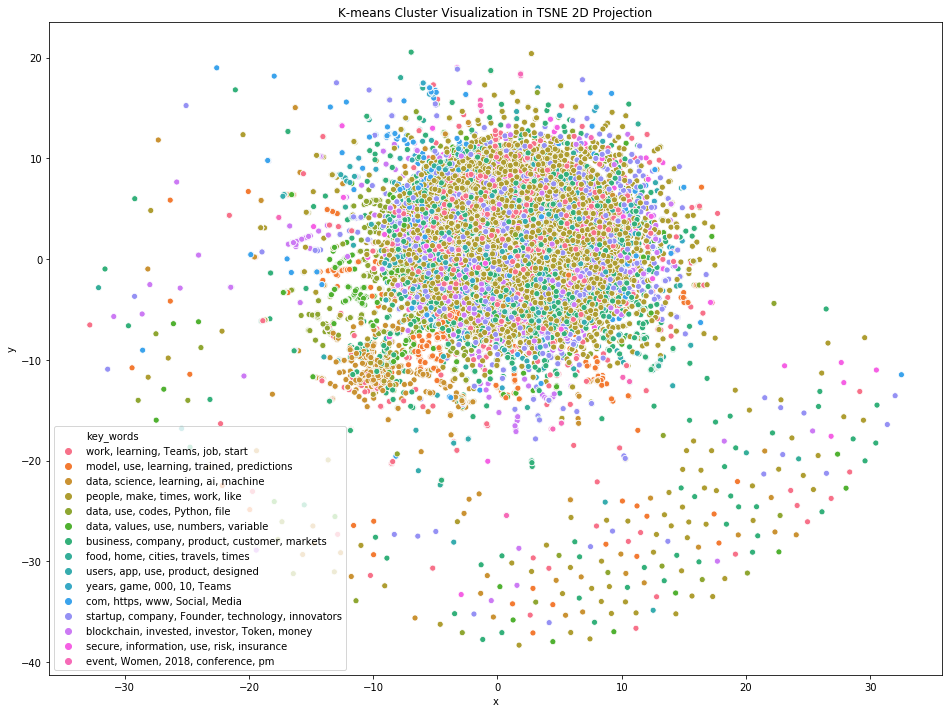

In [114]:
# get 2-D representation of our data
# X_tsne_embedded = TSNE(n_components=2, random_state=99).fit_transform(tfidf_matrix.toarray())
X_tsne_embedded = pd.read_pickle('../data/tsne_embedded.pkl')
# convert to dataframe for visualization
df_tsne = pd.DataFrame(X_tsne_embedded, columns=['x', 'y'])
df_tsne['topic'] = df_topics['topic'].copy().values
df_tsne['key_words'] = df_tsne['topic'].map(topic_keywords).apply(lambda x: ', '.join(x))

# plot
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('K-means Cluster Visualization in TSNE 2D Projection')
sns.scatterplot(
    x="x",
    y="y",
    hue='key_words',
    data=df_tsne,
    ax=ax
)

## Sementic indexing

In [136]:
# get similarity matrix using lda matrix
# sim_matrix = cosine_similarity(lda_matrix)
# get the one with most claps
blog_idx = df[df.claps == df.claps.max()].index[0]
# query the top 10 most simular blog post
df.loc[np.argsort(sim_matrix[blog_idx])[::-1][:10]]

,title,publish_time,author,url,author_url,headings,contents,mins_read,claps,lang,tags
9276,You Make Or Break Your Life Between 5-7 AM – T...,2018-01-10,Benjamin P. Hardy,https://medium.com/thrive-global/you-make-or-b...,https://medium.com/@benjaminhardy,You Make Or Break Your Life Between 5-7 AM You...,While serving a humanitarian and ecclesiastica...,10,103000,en,"[Self Improvement, Productivity, Entrepreneurs..."
16871,Battling Overwhelm – The Happy Startup School ...,2018-05-01,Mike Strange,https://medium.com/the-happy-startup-school/ba...,https://medium.com/@mikejstrange,Battling Overwhelm It’s not easy when it’s all...,I’ve been self employed one way or another for...,7,580,en,"[Life Lessons, Entrepreneurship, Freelancing, ..."
14466,Can you win? – Nate T. – Medium,2018-04-01,Nate T.,https://medium.com/@nateproduct/can-you-win-94...,https://medium.com/@nateproduct,Can you win?,I heard some great advice on building a great ...,2,0,en,[Startup]
23320,10 Ways To Determine If You Have Healthy Or De...,2018-08-11,Benjamin P. Hardy,https://medium.com/thrive-global/10-questions-...,https://medium.com/@benjaminhardy,10 Ways To Determine If You Have Healthy Or De...,“Passion” gets a lot of bad press these days. ...,12,7500,en,"[Self Improvement, Life, Life Lessons, Psychol..."
10140,Two Options Shut Up And Do It Or Quit- Yep I S...,2018-01-18,Megan Anderson,https://medium.com/@megan_5790/two-options-shu...,https://medium.com/@megan_5790,Two Options Shut Up And Do It Or Quit- Yep I S...,"I hate this crap, why does everything have to ...",3,4,en,"[Entrepreneurship, Startup Lessons, Business, ..."
21121,"It’s not the solution, it’s the Problem – Jdow...",2018-07-01,Jdowfernandez,https://medium.com/@Jdowfernandez/its-not-the-...,https://medium.com/@Jdowfernandez,"It’s not the solution, it’s the Problem","Lots of people, wake up one day and realize th...",2,0,en,[Startup]
22610,13 Things You Should Give Up If You Want To Be...,2018-07-30,Zdravko Cvijetic,https://medium.com/thrive-global/13-things-you...,https://medium.com/@zdravko,13 Things You Should Give Up If You Want To Be...,"“On your last day on earth, the person you bec...",6,15600,en,"[Startup, Life, Life Lessons, Entrepreneurship..."
14663,Do You Have Enough Hunger To Succeed? – The St...,2018-04-03,Pramod Chandrayan,https://medium.com/swlh/all-i-have-to-share-is...,https://medium.com/@pramod.pandey83,Do You Have Enough Hunger To Succeed? Is It Re...,Nobody in this world wants to be a failure isn...,5,483,en,"[Entrepreneurship, Startup, Life Lessons, Inno..."
17832,Linkybrains 8 weeks old:) – doug_scott – Medium,2018-05-16,doug_scott,https://medium.com/@doug_scott/linkybrains-ebe...,https://medium.com/@doug_scott,,Linkybrains 8 weeks old:) #Linkybrains I am go...,4,112,en,"[Startup, Linkybrains]"
16879,Saying Thank You Is The #1 Skill You Need – Jo...,2018-05-01,Jon Westenberg 🌈,https://medium.com/@jonwestenberg/saying-thank...,https://medium.com/@jonwestenberg,Saying Thank You Is The #1 Skill You Need Dail...,If you don’t stop to thank the person who make...,4,837,en,"[Life, Life Lessons, Startup, Entrepreneurship..."
